# Install dependencies and import libraries


In [ ]:
!pip install -U "ibis-framework[duckdb]"
!pip install gdown
!pip install sdv
!pip install optuna

In [ ]:
import pandas as pd
import gdown
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import gdown
import ibis
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import Metadata
from tqdm import tqdm
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import optuna
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

# Download Data

Actual code for all data but commented out

In [ ]:
# if not os.path.exists("student-performance/test.csv"):
#     !gdown --folder https://drive.google.com/drive/folders/1d1_DVmZkIJsNPSbZG6gwzQDx33zhyWo1?usp=sharing -O student-performance
# else:
#     print("Data already downloaded.")

In [ ]:
# Create the folder if it doesn't exist
output_folder = "student-performance"
os.makedirs(output_folder, exist_ok=True)

file_id = "1u4edCFSJ2uwikVm4f_2RTEDqr1aPgEAL"
gdrive_url = f"https://drive.google.com/uc?id={file_id}"

# Set the output path to be inside the student-performance folder
output_file_train = os.path.join(output_folder, "train.csv")
output_file_test = os.path.join(output_folder, "test.csv")
output_file_validation = os.path.join(output_folder, "validation.csv")

# Download the file
gdown.download(gdrive_url, output_file_train, quiet=False)
gdown.download(gdrive_url, output_file_test, quiet=False)
gdown.download(gdrive_url, output_file_validation, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1u4edCFSJ2uwikVm4f_2RTEDqr1aPgEAL
To: /content/student-performance/train.csv
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1u4edCFSJ2uwikVm4f_2RTEDqr1aPgEAL
To: /content/student-performance/test.csv
100%|██████████| 1.65M/1.65M [00:00<00:00, 31.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1u4edCFSJ2uwikVm4f_2RTEDqr1aPgEAL
To: /content/student-performance/validation.csv
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.1MB/s]


'student-performance/validation.csv'

In [ ]:
# Reset the DuckDB database
if os.path.exists("student_performance.duckdb"):
    os.remove("student_performance.duckdb")

con = ibis.duckdb.connect("student_performance.duckdb")

# Register CSVs as DuckDB tables
test = con.read_csv("student-performance/test.csv", table_name="test")
train = con.read_csv("student-performance/train.csv", table_name="train")
validation = con.read_csv("student-performance/validation.csv", table_name="validation")

# Synthesize Data

In [ ]:
all_data_expr = train.union(test).union(validation)
sample_df = all_data_expr.to_pandas()

In [ ]:
# Load or detect metadata
if os.path.exists("metadata.json"):
    metadata = Metadata.load_from_json("metadata.json")
else:
    metadata = Metadata.detect_from_dataframe(sample_df)
    metadata.save_to_json("metadata.json")

# Load or fit synthesizer
if os.path.exists("GaussianCopulaSynthesizer.pkl"):
    synthesizer = GaussianCopulaSynthesizer.load("GaussianCopulaSynthesizer.pkl")
else:
    synthesizer = GaussianCopulaSynthesizer(metadata)
    synthesizer.fit(sample_df)
    synthesizer.save("GaussianCopulaSynthesizer.pkl")

In [ ]:
# Generate 50M synthetic rows in 1M-row chunks and write directly to DuckDB
total_rows = 50_000
chunk_size = 1_000
num_chunks = total_rows // chunk_size

# Create DuckDB connection
if os.path.exists("student_performance.duckdb"):
    os.remove("student_performance.duckdb")
con = ibis.duckdb.connect("student_performance.duckdb")

for i in tqdm(range(num_chunks)):
    chunk_df = synthesizer.sample(chunk_size)

    if i == 0:
        # First chunk: create table
        con.create_table("synthetic", chunk_df)
    else:
        # Subsequent chunks: append to table
        con.create_table("chunk_df", chunk_df, overwrite=True)
        con.raw_sql("INSERT INTO synthetic SELECT * FROM chunk_df")


  0%|          | 0/50 [00:00<?, ?it/s]


CatalogException: Catalog Error: Table with name "synthetic" already exists!

# Data Cleaning

In [ ]:
# Connect to DuckDB database
con = ibis.duckdb.connect("student_performance.duckdb")

# Read from the synthetic table (already created)
synthetic_table = con.table("synthetic")

# Convert to Pandas DataFrame
df = synthetic_table.execute()
print(df.head())

   Age  Grade  Gender      Race  SES_Quartile ParentalEducation SchoolType  \
0   14      9  Female     Asian             3        Bachelors+     Public   
1   18      9  Female     Black             1       SomeCollege     Public   
2   14     11    Male  Hispanic             4        Bachelors+     Public   
3   14      9  Female     White             3       SomeCollege    Private   
4   15     10    Male     White             3       SomeCollege     Public   

     Locale  TestScore_Math  TestScore_Reading  ...       GPA  AttendanceRate  \
0      City       68.123836          68.579246  ...  2.407713        0.892364   
1  Suburban       74.419576          88.464864  ...  3.476256        0.955092   
2      Town       75.680509          74.445292  ...  3.144588        0.846210   
3      City       78.821700          66.857081  ...  2.161962        0.880487   
4     Rural       74.381032          79.107045  ...  2.544607        0.913533   

   StudyHours  InternetAccess  Extracurricul

In [ ]:

# Basic info
print("📋 DataFrame Info:")
df.info()

# Descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe(include="all"))

# Value counts for all categorical/object columns
print("\nValue Counts:")
for col in df.select_dtypes(include="object").columns:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())

# Missing data analysis
print("\nMissing Data Analysis:")
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    "Missing Values": missing,
    "Percentage": missing_percent
})
print(missing_df[missing_df["Missing Values"] > 0])

📋 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                50000 non-null  int64  
 1   Grade              50000 non-null  int64  
 2   Gender             50000 non-null  object 
 3   Race               50000 non-null  object 
 4   SES_Quartile       50000 non-null  int64  
 5   ParentalEducation  50000 non-null  object 
 6   SchoolType         50000 non-null  object 
 7   Locale             50000 non-null  object 
 8   TestScore_Math     50000 non-null  float64
 9   TestScore_Reading  50000 non-null  float64
 10  TestScore_Science  50000 non-null  float64
 11  GPA                50000 non-null  float64
 12  AttendanceRate     50000 non-null  float64
 13  StudyHours         50000 non-null  float64
 14  InternetAccess     50000 non-null  int64  
 15  Extracurricular    50000 non-null  int64  
 16  Part

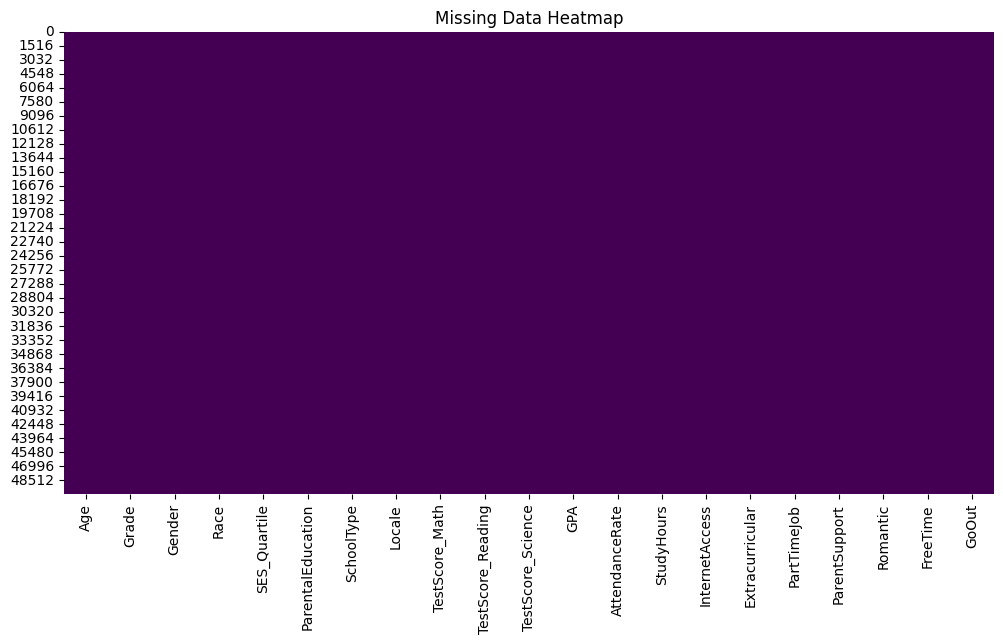

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()


In [ ]:
# Drop rows with NaN values and duplicates
df = df.dropna().drop_duplicates()

# Drop columns with too many categories
threshold = 50
drop_cols = [col for col in df.select_dtypes(include='object').columns if df[col].nunique() > threshold]
df = df.drop(columns=drop_cols)

# Convert GPA to bins with labels
bins = [0, 2.5, 3.0, 3.5, 4.01]
labels = [
    "Low (0.00–2.49)",
    "Mid-Low (2.50–2.99)",
    "Mid-High (3.00–3.49)",
    "High (3.50–4.00)"
]
df["GPA_bins"] = pd.cut(
    df["GPA"], bins=bins, labels=labels, include_lowest=True, right=False
)

print(df["GPA_bins"].value_counts())

GPA_bins
Mid-High (3.00–3.49)    17993
Mid-Low (2.50–2.99)     17521
Low (0.00–2.49)          7591
High (3.50–4.00)         6895
Name: count, dtype: int64


# EDA

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


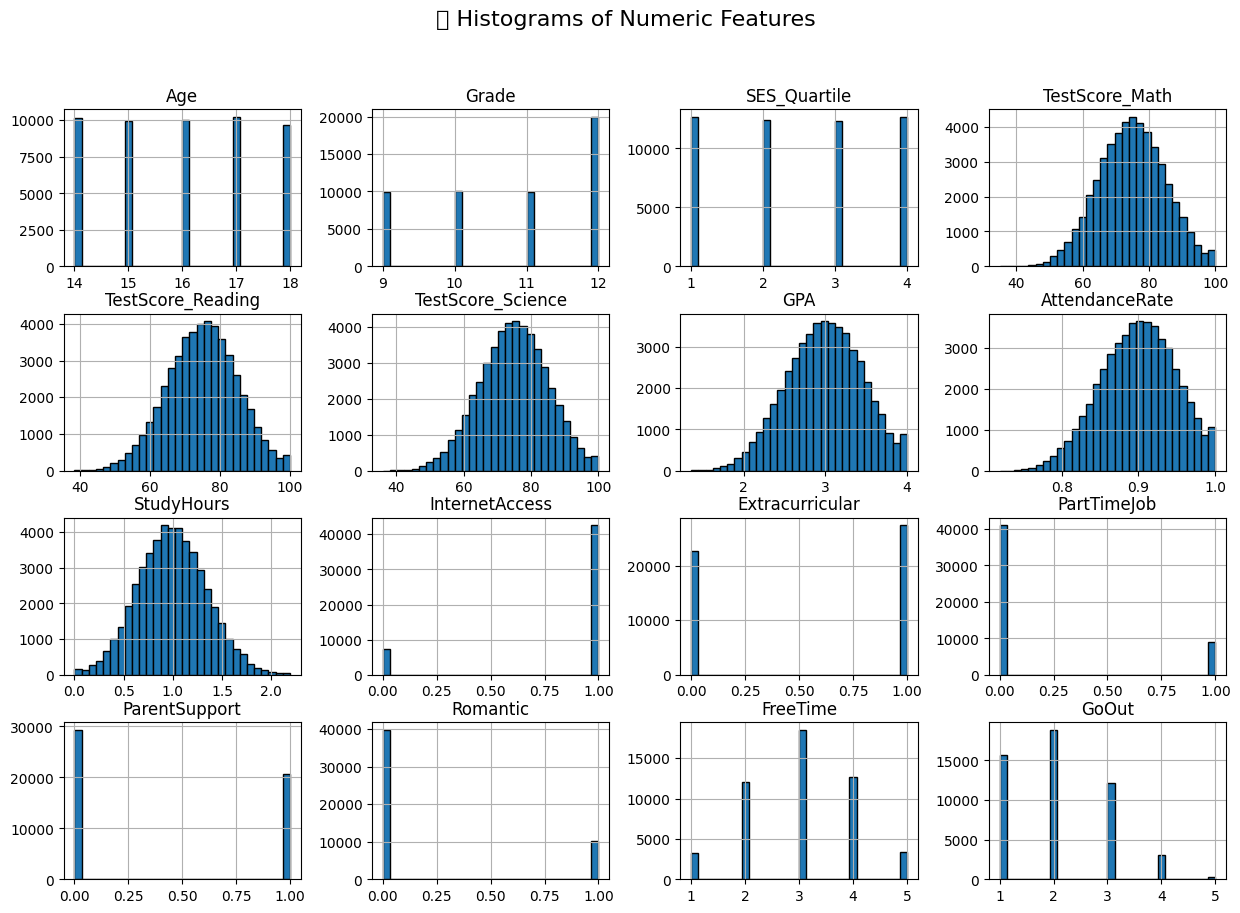

In [ ]:
df.select_dtypes(include=[np.number]).hist(
    bins=30, figsize=(15, 10), edgecolor="black"
)
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.show()



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


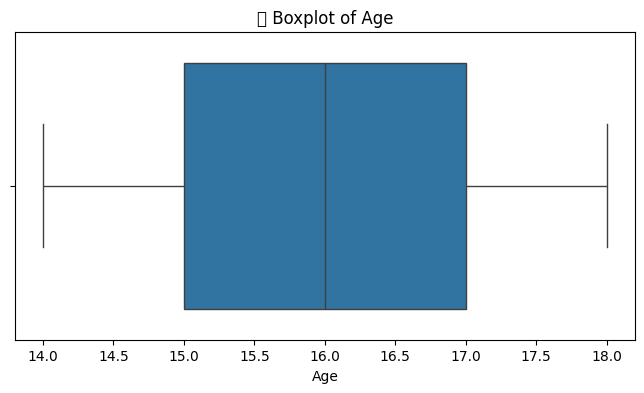

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


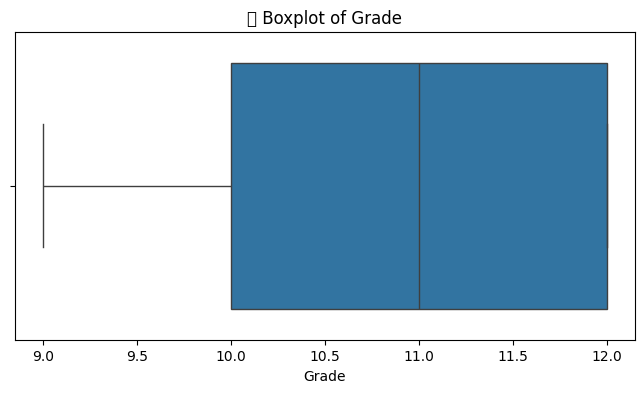

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


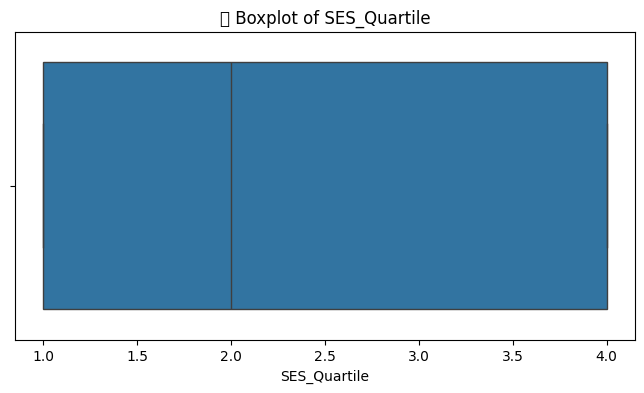

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


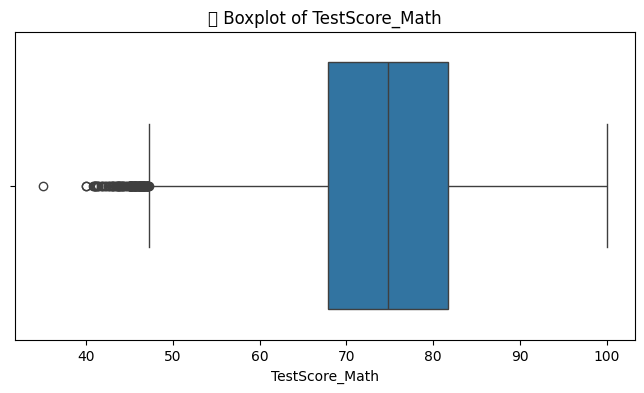

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


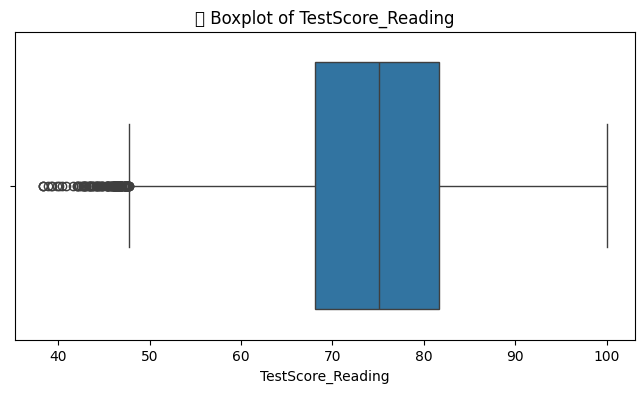

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


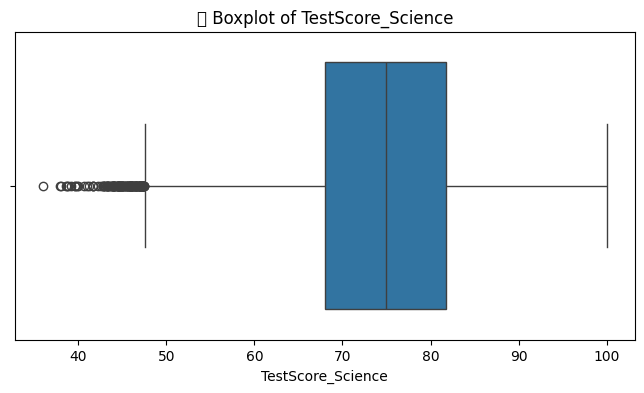

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


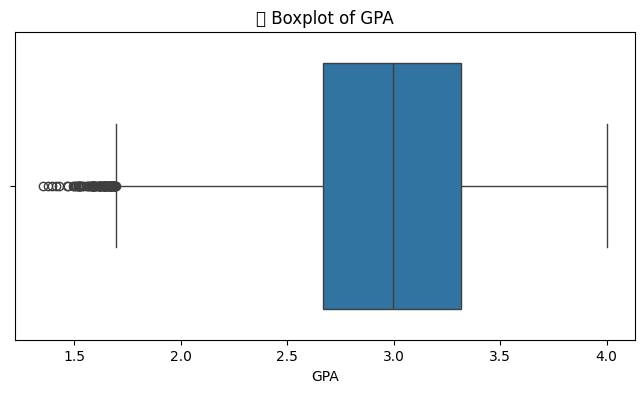

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


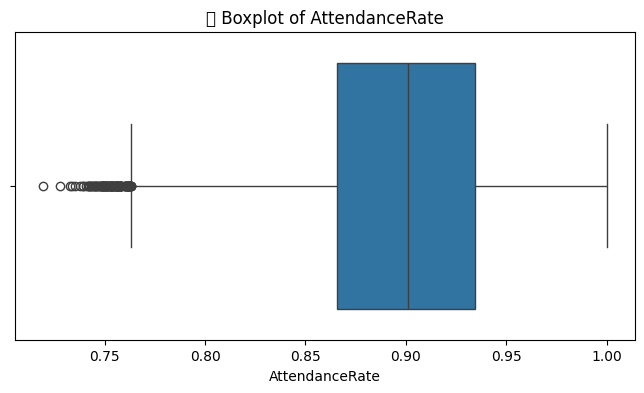

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


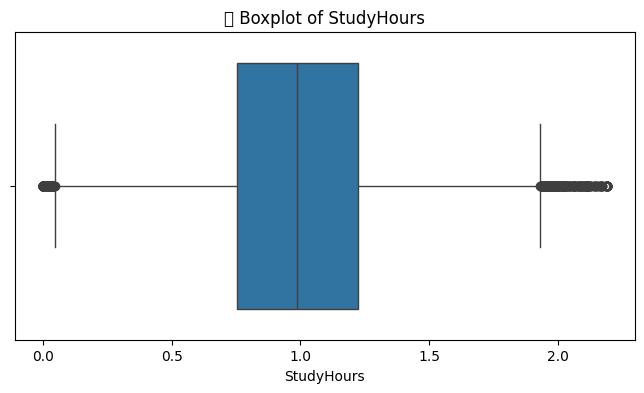

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


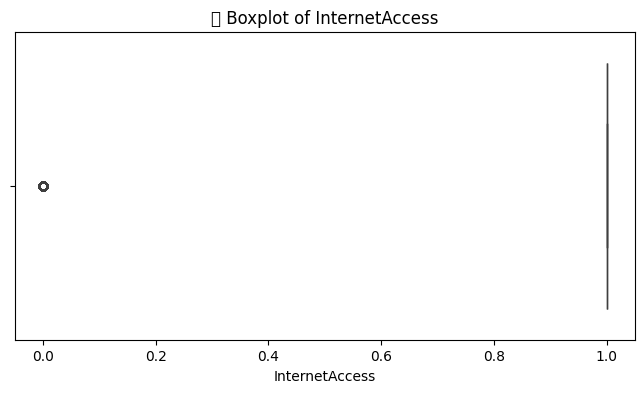

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


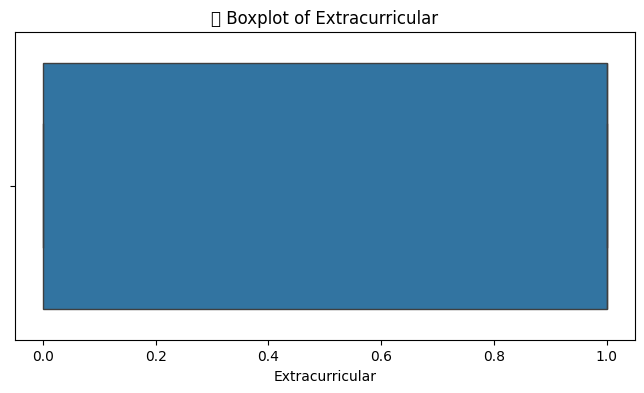

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


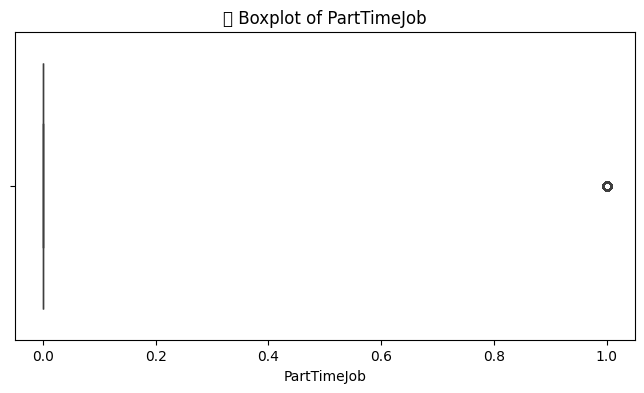

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


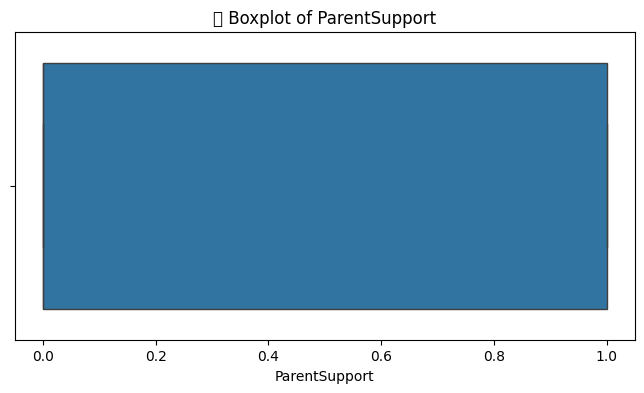

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


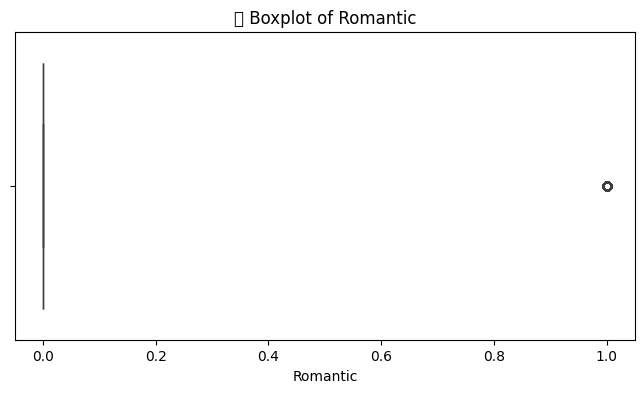

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


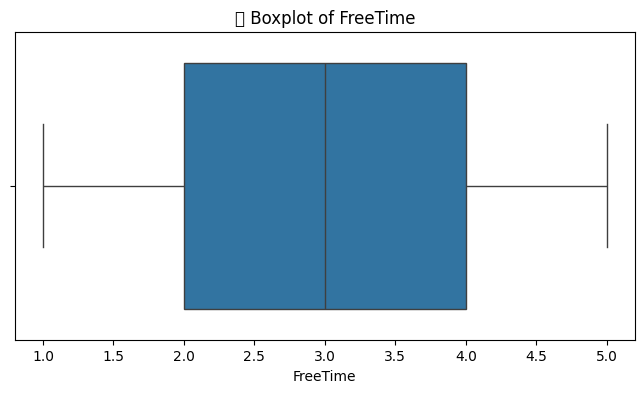

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


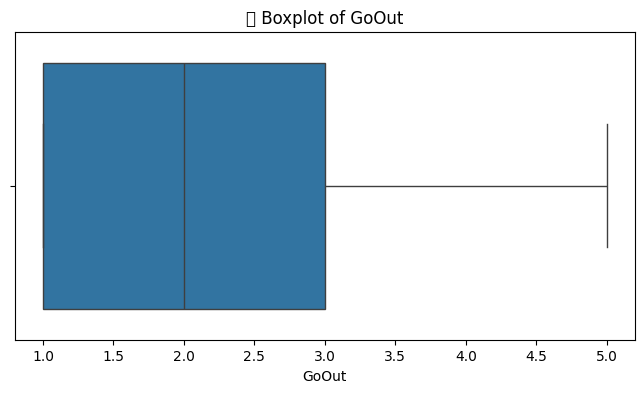

In [ ]:
for col in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


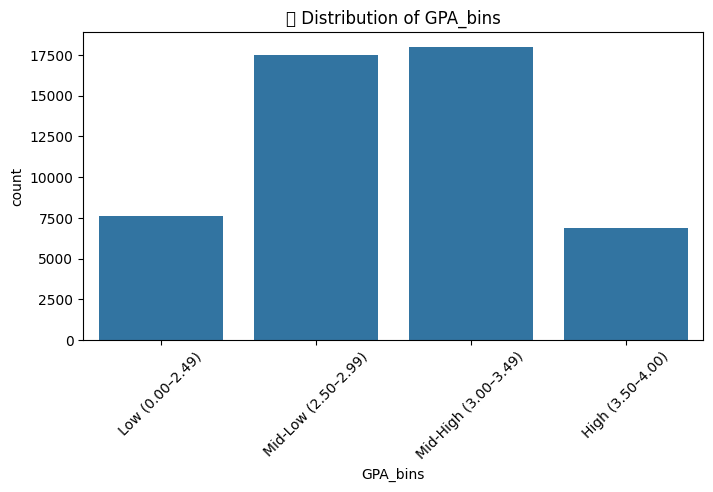

In [ ]:
for col in df.select_dtypes(include="category").columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


# Feature Selection

In [ ]:
# Select numeric features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric Features:")
for col in numeric_features:
    print(f"  - {col}")


Numeric Features:
  - Age
  - Grade
  - SES_Quartile
  - TestScore_Math
  - TestScore_Reading
  - TestScore_Science
  - GPA
  - AttendanceRate
  - StudyHours
  - InternetAccess
  - Extracurricular
  - PartTimeJob
  - ParentSupport
  - Romantic
  - FreeTime
  - GoOut


In [ ]:
# Categorical features
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("\nCategorical Features:")
for col in categorical_features:
    print(f"  - {col}")



Categorical Features:
  - Gender
  - Race
  - ParentalEducation
  - SchoolType
  - Locale
  - GPA_bins


PCA reduced 16 features → 13 components


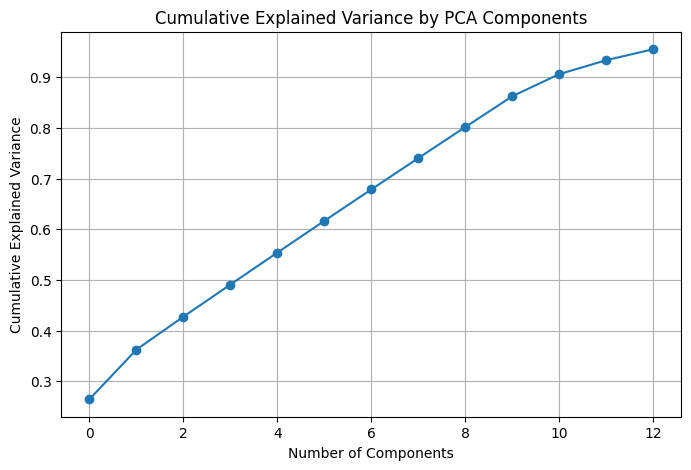

In [ ]:
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df[numeric_features])

# Apply PCA (retain 95% variance)
pca = PCA(n_components=0.95)
pca_numeric = pca.fit_transform(scaled_numeric)

# PCA Summary
print(f"PCA reduced {len(numeric_features)} features → {pca.n_components_} components")

# Create PCA DataFrame
pca_columns = [f"PCA_{i+1}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_numeric, columns=pca_columns)

# Replace numeric features in original df
df_pca = pd.concat([df.drop(columns=numeric_features).reset_index(drop=True), pca_df], axis=1)

# Scree Plot (Variance Explained)
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [ ]:
# Encode target variable
target = "GPA_bins"
y_encoded = LabelEncoder().fit_transform(df[target])

# Select categorical features
categorical_features = [
    col for col in categorical_features if col != target
]
print("Categorical Features:", categorical_features)

# One-hot encode categorical features
X_cat = pd.get_dummies(df[categorical_features], drop_first=True)

# Apply Chi-square test
chi_scores, p_values = chi2(X_cat, y_encoded)

# Chi squared Results DataFrame
chi2_df = pd.DataFrame({
    "Feature": X_cat.columns,
    "Chi2 Score": chi_scores,
    "p-value": p_values
}).sort_values("Chi2 Score", ascending=False)

print("Chi squared Feature Ranking:")
print(chi2_df)



Categorical Features: ['Gender', 'Race', 'ParentalEducation', 'SchoolType', 'Locale']
Chi squared Feature Ranking:
                          Feature  Chi2 Score   p-value
7            ParentalEducation_HS   14.608354  0.002184
6    ParentalEducation_Bachelors+   10.878928  0.012399
0                     Gender_Male    7.414020  0.059809
10                   Locale_Rural    7.274521  0.063644
11                Locale_Suburban    5.265710  0.153343
4                Race_Two-or-more    5.010054  0.171062
1                      Race_Black    4.955174  0.175109
3                      Race_Other    4.219729  0.238694
8   ParentalEducation_SomeCollege    3.846146  0.278564
2                   Race_Hispanic    2.028632  0.566485
12                    Locale_Town    0.821986  0.844201
9               SchoolType_Public    0.497348  0.919474
5                      Race_White    0.438343  0.932213


In [ ]:
# Keep features with p-value < 0.1
significant_features = chi2_df[chi2_df["p-value"] < 0.1]["Feature"].tolist()

print(f"Statistically Significant Features (p < 0.1): {len(significant_features)}")
print(significant_features)


Statistically Significant Features (p < 0.1): 4
['ParentalEducation_HS', 'ParentalEducation_Bachelors+', 'Gender_Male', 'Locale_Rural']


In [ ]:
# Keep only significant dummy features from X_cat
X_cat_significant = X_cat[significant_features]

# Combine PCA components + significant categorical features + target
df_selected = pd.concat([
    pca_df.reset_index(drop=True),
    X_cat_significant.reset_index(drop=True),
    df[target].reset_index(drop=True)
], axis=1)

print(f"\Final df_selected Shape: {df_selected.shape}")
print(df_selected.head())


🎯 Final df_selected Shape: (50000, 18)
      PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0 -1.299193 -2.065244  0.492465  2.037444 -0.353005  1.871519  1.274974   
1  1.877892  0.060528 -0.361655 -0.358321  1.981278 -1.927787  0.277213   
2 -0.606577 -0.912980  0.491572 -0.374678  0.496490  1.951778 -0.865319   
3 -1.339103 -2.145360 -0.287233 -0.939129 -0.711283  1.075856  0.546360   
4  0.376329 -1.024949  1.654048  0.044740 -0.119935 -1.132523 -0.968928   

      PCA_8     PCA_9    PCA_10    PCA_11    PCA_12    PCA_13  \
0  1.085645  1.086212  0.741303  0.347407  0.103037 -0.777899   
1 -0.526270 -1.256735 -0.653183 -0.463062  2.099972  0.181386   
2 -0.702557 -0.530774  0.567195 -0.230303 -1.140369  0.703113   
3 -0.006122 -0.478863  0.132930 -0.176559  0.110325 -1.424353   
4 -0.504878  0.348795 -0.632160  1.154303 -0.001775 -0.943476   

   ParentalEducation_HS  ParentalEducation_Bachelors+  Gender_Male  \
0                 False                         

In [ ]:
df_target = df["GPA_bins"]
df = df_selected

# Training and Hyperparameter Tuning

In [ ]:
X = df
y = df_target

# Prepare target variable for training
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Use class weights to address imbalance of target categories
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
weight_dict = {i: w for i, w in enumerate(class_weights)}

# Make sure correct datatype is used
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype("category")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

sample_weights = np.array([weight_dict[label] for label in y_train])

In [ ]:
# Get subest
max_rows = 100_000

if len(df_selected) > max_rows:
    df_subset = df_selected.sample(n=max_rows, random_state=42)
    print(f"Subset limited to {max_rows} rows for Optuna.")
else:
    df_subset = df_selected.copy()
    print(f"Using all {len(df_subset)} rows (data <= {max_rows}).")

X = df_subset.drop(columns=[target])
y = LabelEncoder().fit_transform(df_subset[target])

# Split subset into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Set range of parameters
def objective(trial):
    params = {
        "objective": "multi:softprob",
        "num_class": 4,
        "eval_metric": "mlogloss",
        "enable_categorical": True,
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
        "random_state": 42,
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

# Start Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-07-03 21:04:59,213] A new study created in memory with name: no-name-fa0c58bb-566e-4046-8817-0d0ca192d31f


✅ Using all 50000 rows (data <= 100000).


[I 2025-07-03 21:05:26,285] Trial 0 finished with value: 0.9315 and parameters: {'max_depth': 8, 'learning_rate': 0.01974976523528155, 'n_estimators': 295, 'subsample': 0.6042790962227909, 'colsample_bytree': 0.5421312788330119, 'gamma': 0.748728796769732, 'reg_alpha': 0.45842167773476716, 'reg_lambda': 0.7642092086357728}. Best is trial 0 with value: 0.9315.
[I 2025-07-03 21:05:35,444] Trial 1 finished with value: 0.8751 and parameters: {'max_depth': 8, 'learning_rate': 0.01776014770271923, 'n_estimators': 111, 'subsample': 0.944727777203827, 'colsample_bytree': 0.5116172602797351, 'gamma': 0.7409185455192934, 'reg_alpha': 0.7673165585277184, 'reg_lambda': 0.9673210841318125}. Best is trial 0 with value: 0.9315.
[I 2025-07-03 21:05:51,613] Trial 2 finished with value: 0.9534 and parameters: {'max_depth': 9, 'learning_rate': 0.035917181026016855, 'n_estimators': 119, 'subsample': 0.9919263903417764, 'colsample_bytree': 0.9160414740092, 'gamma': 0.18899380160488743, 'reg_alpha': 0.86756

In [ ]:
print("Best trial:")
print("Accuracy:", study.best_value)
print("Params:", study.best_params)

Best trial:
Accuracy: 0.9595
Params: {'max_depth': 6, 'learning_rate': 0.12980713554357004, 'n_estimators': 226, 'subsample': 0.5032568487298386, 'colsample_bytree': 0.9922958005048221, 'gamma': 0.43416711577291767, 'reg_alpha': 0.22056821361310452, 'reg_lambda': 0.4216244850972935}


In [ ]:
# Prepare and Train Best model
best_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=4,
    eval_metric="mlogloss",
    enable_categorical=True,
    **study.best_params
)
best_model.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9922958005048221, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.43416711577291767, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.12980713554357004,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=226, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

# Visualize Results

Accuracy: 0.9559

Classification Report:
                      precision    recall  f1-score   support

    High (3.50–4.00)       0.95      0.94      0.95      1379
     Low (0.00–2.49)       0.96      0.96      0.96      1518
Mid-High (3.00–3.49)       0.95      0.96      0.96      3599
 Mid-Low (2.50–2.99)       0.96      0.96      0.96      3504

            accuracy                           0.96     10000
           macro avg       0.96      0.95      0.96     10000
        weighted avg       0.96      0.96      0.96     10000



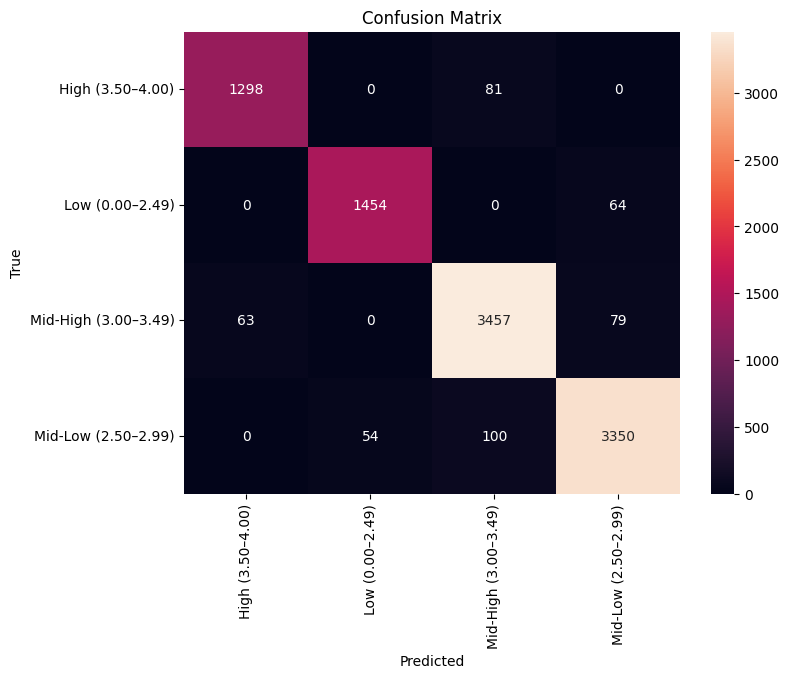

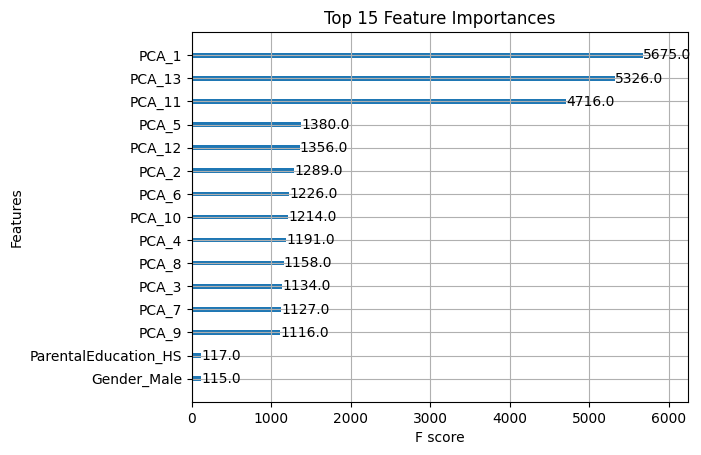

In [ ]:
# Metrics and Visualizations
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Feature importances
xgb.plot_importance(best_model, max_num_features=15)
plt.title("Top 15 Feature Importances")
plt.show()

In [ ]:
# Combine df_selected with original target column
df_combined = pd.concat([df_selected.reset_index(drop=True), df_target.reset_index(drop=True)], axis=1)

# Save to CSV
output_path = "student_performance_selected.csv"
df_combined.to_csv(output_path, index=False)

print(f"Combined DataFrame saved to: {output_path}")
print(f"Shape of saved DataFrame: {df_combined.shape}")


Combined DataFrame saved to: student_performance_selected.csv
Shape of saved DataFrame: (50000, 19)
